In [1]:
#fastai study group.  learning to do a competition in Kaggle.
#my code compilation

#11/22/2020 Compile clean draft, based on fastai-2020 study course
#     make it work like 09-tabular
#     no bells no whistles
#    simple: merge features & targets, get lr min recommendation, learn and relearn.
#     expect a score ~.02025

#11/28/2020 Add cross-validation, multilable stratified k-fold
#     from iterstrat.ml_stratifiers import MultilabelStratifiedKFold 
#     src: https://www.kaggle.com/robertlangdonvinci/lish-moa-kfold-fastai-tabnet-ensemble/data?select=ml_stratifiers.py
#
#     $note tried sklearn 
#     https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
#     UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.

#11/29/2020 Set initial lr
#     lr =.001 or determine dynamically in 0th fold
#     expect similar score ~.01972, got .01987 ok
#     misc edits: tried y_range=(0,1) but then train_loss and valid_loss are same everywhere

#11/29/2020 Set initial lr dynamically, don't train on controls
#     expect similar score ~range (.01972,.01987) got .01974 ok

#11/29/2020 Change layers, epochs, wd.
#     expect similar score ~range (.01972,.01987)


#next: params grid
#next: incorporate non-scoredMultilabelStratifiedKFold

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv


In [3]:
#modeling
from fastai.tabular.all import *


In [4]:
#cross-validation
from ml_stratifiers import MultilabelStratifiedKFold

/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv


In [5]:
#src: https://www.kaggle.com/robertlangdonvinci/lish-moa-kfold-fastai-tabnet-ensemble/data?select=ml_stratifiers.py
def make_folds(folds = 5, random_state = 0, stratify = True, scored = None):
    
    drug = pd.read_csv('../input/lish-moa/train_drug.csv')
    if scored is None:
        scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left')

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[vc<=18].index.sort_values()
    vc2 = vc.loc[vc>18].index.sort_values()

    # STRATIFY DRUGS 18 OR LESS
    dct1 = {}; dct2 = {}
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.index[idxV].values}
        dct1.update(dd)
    
    # STRATIFY DRUGS MORE THAN 18
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop=True)
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.sig_id[idxV].values}
        dct2.update(dd)
    
    # ASSIGN FOLDS
    scored['fold'] = np.nan
    scored['fold'] = scored.drug_id.map(dct1)
    scored.loc[scored.fold.isna(),'fold'] = scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
    scored.fold = scored.fold.astype('int8')
    
    return scored[['sig_id','fold']].copy()

## 0. Load Data

In [6]:
path = Path('../input/lish-moa')
path.ls()

(#6) [Path('../input/lish-moa/train_features.csv'),Path('../input/lish-moa/train_drug.csv'),Path('../input/lish-moa/test_features.csv'),Path('../input/lish-moa/train_targets_nonscored.csv'),Path('../input/lish-moa/sample_submission.csv'),Path('../input/lish-moa/train_targets_scored.csv')]

In [7]:
train_drug = pd.read_csv(path/'train_drug.csv')

print('train drug data\n', train_drug.shape)
display(train_drug.head(3))
train_drug.describe()

train drug data
 (23814, 2)


,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c


,sig_id,drug_id
count,23814,23814
unique,23814,3289
top,id_6a2030888,cacb2b860
freq,1,1866


In [8]:
train_drug['drug_id'].value_counts()

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
d70cdde82       1
d532d49de       1
547f80a41       1
6bb340664       1
ffe357f8f       1
Name: drug_id, Length: 3289, dtype: int64

In [9]:
train_features = pd.read_csv(path/'train_features.csv')
train_targets_scored = pd.read_csv(path/'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(path/'train_targets_nonscored.csv')
test_features = pd.read_csv(path/'test_features.csv')


In [10]:
print('train features', train_features.shape)
print('train targets', train_targets_scored.shape)
print('test features', test_features.shape)

display(train_features.head(3))
display(train_targets_scored.head(3))

train features (23814, 876)
train targets (23814, 207)
test features (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 0.1 EDA

In [11]:
train_features.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [12]:
train_features.groupby(['cp_type', 'cp_time', 'cp_dose'])[['sig_id']].count(), test_features.groupby(['cp_type', 'cp_time', 'cp_dose'])[['sig_id']].count()

(                             sig_id
 cp_type     cp_time cp_dose        
 ctl_vehicle 24      D1          301
                     D2          305
             48      D1          343
                     D2          305
             72      D1          307
                     D2          305
 trt_cp      24      D1         3585
                     D2         3581
             48      D1         4011
                     D2         3591
             72      D1         3600
                     D2         3580,
                              sig_id
 cp_type     cp_time cp_dose        
 ctl_vehicle 24      D1           58
                     D2           58
             48      D1           65
                     D2           59
             72      D1           59
                     D2           59
 trt_cp      24      D1          590
                     D2          594
             48      D1          660
                     D2          593
             72      D1          595


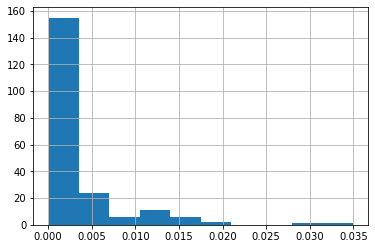

In [13]:
train_targets_scored.iloc[1:].mean().hist()

In [14]:
train_target_distrib = dict(train_targets_scored.iloc[:,1:].sum())
train_target_distrib

{'5-alpha_reductase_inhibitor': 17,
 '11-beta-hsd1_inhibitor': 18,
 'acat_inhibitor': 24,
 'acetylcholine_receptor_agonist': 190,
 'acetylcholine_receptor_antagonist': 301,
 'acetylcholinesterase_inhibitor': 73,
 'adenosine_receptor_agonist': 54,
 'adenosine_receptor_antagonist': 96,
 'adenylyl_cyclase_activator': 12,
 'adrenergic_receptor_agonist': 270,
 'adrenergic_receptor_antagonist': 360,
 'akt_inhibitor': 66,
 'aldehyde_dehydrogenase_inhibitor': 7,
 'alk_inhibitor': 42,
 'ampk_activator': 12,
 'analgesic': 12,
 'androgen_receptor_agonist': 48,
 'androgen_receptor_antagonist': 89,
 'anesthetic_-_local': 80,
 'angiogenesis_inhibitor': 36,
 'angiotensin_receptor_antagonist': 37,
 'anti-inflammatory': 73,
 'antiarrhythmic': 6,
 'antibiotic': 43,
 'anticonvulsant': 12,
 'antifungal': 13,
 'antihistamine': 12,
 'antimalarial': 18,
 'antioxidant': 73,
 'antiprotozoal': 36,
 'antiviral': 23,
 'apoptosis_stimulant': 49,
 'aromatase_inhibitor': 47,
 'atm_kinase_inhibitor': 6,
 'atp-sensiti

In [15]:
[(k,train_target_distrib[k]) for k in train_target_distrib if train_target_distrib[k] == 1]

[('atp-sensitive_potassium_channel_antagonist', 1), ('erbb2_inhibitor', 1)]

In [16]:
sub = pd.read_csv(path/'sample_submission.csv')
sub.shape

(3982, 207)

## 1. Data Prep

##### Stratified k-folds
Create X & y  
Note: here y is only used for creating k-folds

In [17]:
X_train = train_features.merge(train_targets_scored,on='sig_id',how='left')
print(X_train.shape)

#drop records with no MoAs
X_train = X_train[X_train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
print(X_train.shape)

(23814, 1082)
(21948, 1082)


In [18]:
y_train = X_train[train_targets_scored.columns]
X_train.shape, y_train.shape


((21948, 1082), (21948, 207))

In [19]:
#crossvalidation with stratified k-fold
FOLDS = 10; SEED = 24
skf = make_folds(folds=FOLDS, random_state=SEED, stratify=True, scored=y_train)

X_train['kfold'] = skf.fold.values
X_train.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,4
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,2
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,9
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,9
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,7


##### TabularPandas and TabularProc

TabularPandas needs to be told which columns are continuous and which are categorical.  
Note: can handle that automatically using the helper function cont_cat_split (not used here).

In [20]:
#handpick 
cat_names = L(list(train_features.columns[1:4]))
cont_names = L(list(train_features.columns[4:]))
cat_names, cont_names

((#3) ['cp_type','cp_time','cp_dose'],
 (#872) ['g-0','g-1','g-2','g-3','g-4','g-5','g-6','g-7','g-8','g-9'...])

In [21]:
#define target vars
dep_var = list(train_targets_scored.columns[1:])
dep_var[:10]


['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist']

## 2. Model

Define dls

In [22]:
procs = [FillMissing, Categorify, Normalize]
def get_data(fold):
    val_idx = X_train[X_train['kfold']==fold].index
    #print(val_idx.shape)
    dls = TabularDataLoaders.from_df(X_train, path=path, y_names=dep_var,
                                        cat_names = cat_names,
                                        cont_names = cont_names,
                                        procs = procs,
                                        valid_idx=val_idx,
                                        bs=64)
    return dls #class fastai.tabular.data.TabularDataLoaders

Train k-folds

In [23]:
torch.cuda.empty_cache() 
best_valid = []
lr = 0.002 #None

for i in range(FOLDS):
    print(i, lr)
    dls = get_data(i) # Data
    #len(dls.train),len(dls.valid)
    #dls.show(5)
    
    #setup learner
    learn = tabular_learner(dls, layers=[1200, 1200], loss_func=BCEWithLogitsLossFlat(), model_dir='/kaggle/working/', wd = 3.0)

    #if i==0:       
    #    #set learning rate once
    #    lr1, lr2 = learn.lr_find()
    #    lr = round(lr2, 4)
    #    print(lr)

    name = 'best_model_' + str(i) 
    cb = SaveModelCallback(monitor='valid_loss',fname=name ,mode='min') # Callbacks

    #train
    learn.fit_one_cycle(19, lr, cbs=cb)
    
    #learn.unfreeze()
    learn.fit_one_cycle(5,slice(1e-4),wd=3.6,cbs=cb)
    
    #learn.unfreeze()
    learn.fit_one_cycle(5, slice(1e-5),wd=4.0,cbs=cb)
    
    #load best model
    learn.load(name)
    
    #cb3 = SaveModelCallback(monitor='valid_loss',fname=name ,mode='min') # Callbacks
    #learn.unfreeze()
    #learn.fit_one_cycle(5, slice(1e-6),wd=0.4,cbs=cb3)
    ##load best model
    #learn.load(name)


    losses = np.array(learn.recorder.values)
    best = np.argmin(losses[:,1])
    best_valid.append(losses[best,1])

    #export model
    learn.export('/kaggle/working/'+name+'.pkl') 
    
best_valid
    

0 0.002


epoch,train_loss,valid_loss,time
0,0.022661,0.019835,00:05
1,0.019118,0.018913,00:05
2,0.018382,0.018785,00:04
3,0.018884,0.019095,00:05
4,0.019046,0.019331,00:05
5,0.018475,0.019026,00:06
6,0.018388,0.018550,00:04
7,0.017979,0.019245,00:05
8,0.017807,0.018223,00:04
9,0.017322,0.018402,00:05


Better model found at epoch 0 with valid_loss value: 0.019835224375128746.
Better model found at epoch 1 with valid_loss value: 0.01891307719051838.
Better model found at epoch 2 with valid_loss value: 0.018784798681735992.
Better model found at epoch 6 with valid_loss value: 0.018550323322415352.
Better model found at epoch 8 with valid_loss value: 0.018223179504275322.
Better model found at epoch 10 with valid_loss value: 0.017966119572520256.
Better model found at epoch 12 with valid_loss value: 0.017895834520459175.
Better model found at epoch 13 with valid_loss value: 0.017762403935194016.
Better model found at epoch 14 with valid_loss value: 0.017711926251649857.


epoch,train_loss,valid_loss,time
0,0.013108,0.017536,00:04
1,0.012579,0.017686,00:04
2,0.012179,0.017770,00:04
3,0.011687,0.017890,00:04
4,0.011215,0.017917,00:04


Better model found at epoch 0 with valid_loss value: 0.017536064609885216.


epoch,train_loss,valid_loss,time
0,0.012518,0.017477,00:05
1,0.012555,0.017505,00:04
2,0.012416,0.017500,00:05
3,0.012341,0.017512,00:05
4,0.012418,0.017512,00:05


Better model found at epoch 0 with valid_loss value: 0.017476540058851242.
1 0.002


epoch,train_loss,valid_loss,time
0,0.022435,0.020398,00:04
1,0.018872,0.019558,00:04
2,0.018241,0.019926,00:04
3,0.018778,0.020327,00:05
4,0.018666,0.019598,00:04
5,0.018363,0.019522,00:05
6,0.018146,0.019596,00:04
7,0.017844,0.019404,00:05
8,0.017366,0.019299,00:05
9,0.017343,0.019306,00:05


Better model found at epoch 0 with valid_loss value: 0.02039758302271366.
Better model found at epoch 1 with valid_loss value: 0.01955796405673027.
Better model found at epoch 5 with valid_loss value: 0.01952187716960907.
Better model found at epoch 7 with valid_loss value: 0.019404031336307526.
Better model found at epoch 8 with valid_loss value: 0.01929868385195732.
Better model found at epoch 10 with valid_loss value: 0.01900874823331833.
Better model found at epoch 11 with valid_loss value: 0.018717167899012566.
Better model found at epoch 12 with valid_loss value: 0.01848195120692253.
Better model found at epoch 13 with valid_loss value: 0.01833748072385788.
Better model found at epoch 14 with valid_loss value: 0.018247954547405243.


epoch,train_loss,valid_loss,time
0,0.012720,0.018285,00:05
1,0.012745,0.018459,00:05
2,0.012019,0.018680,00:04
3,0.011397,0.018799,00:05
4,0.010968,0.018851,00:04


Better model found at epoch 0 with valid_loss value: 0.0182853601872921.


epoch,train_loss,valid_loss,time
0,0.012523,0.018215,00:05
1,0.012430,0.018251,00:04
2,0.012530,0.018291,00:05
3,0.012505,0.018321,00:04
4,0.012342,0.018278,00:05


Better model found at epoch 0 with valid_loss value: 0.01821519248187542.
2 0.002


epoch,train_loss,valid_loss,time
0,0.022560,0.019924,00:05
1,0.019034,0.019040,00:05
2,0.018670,0.019107,00:04
3,0.018760,0.018813,00:05
4,0.018532,0.019239,00:04
5,0.018415,0.018788,00:05
6,0.017900,0.019341,00:05
7,0.018168,0.019068,00:05
8,0.017940,0.018402,00:04
9,0.017612,0.018566,00:04


Better model found at epoch 0 with valid_loss value: 0.019923590123653412.
Better model found at epoch 1 with valid_loss value: 0.019039934501051903.
Better model found at epoch 3 with valid_loss value: 0.018813202157616615.
Better model found at epoch 5 with valid_loss value: 0.018788158893585205.
Better model found at epoch 8 with valid_loss value: 0.0184022169560194.
Better model found at epoch 10 with valid_loss value: 0.01819217950105667.
Better model found at epoch 12 with valid_loss value: 0.018046123906970024.
Better model found at epoch 13 with valid_loss value: 0.017564881592988968.


epoch,train_loss,valid_loss,time
0,0.013600,0.017273,00:04
1,0.013467,0.017378,00:05
2,0.012803,0.017580,00:04
3,0.012424,0.017584,00:05
4,0.011784,0.017605,00:05


Better model found at epoch 0 with valid_loss value: 0.017273250967264175.


epoch,train_loss,valid_loss,time
0,0.013170,0.017249,00:05
1,0.013264,0.017260,00:04
2,0.013043,0.017264,00:04
3,0.012852,0.017263,00:05
4,0.012879,0.017308,00:04


Better model found at epoch 0 with valid_loss value: 0.017249347642064095.
3 0.002


epoch,train_loss,valid_loss,time
0,0.022476,0.020167,00:05
1,0.018954,0.019210,00:04
2,0.018656,0.019255,00:06
3,0.018565,0.019797,00:05
4,0.018645,0.019970,00:05
5,0.018454,0.019837,00:05
6,0.018105,0.019153,00:05
7,0.018096,0.019579,00:04
8,0.017729,0.018927,00:04
9,0.017419,0.018815,00:05


Better model found at epoch 0 with valid_loss value: 0.020167367532849312.
Better model found at epoch 1 with valid_loss value: 0.01921006105840206.
Better model found at epoch 6 with valid_loss value: 0.019153041765093803.
Better model found at epoch 8 with valid_loss value: 0.018927276134490967.
Better model found at epoch 9 with valid_loss value: 0.018814874812960625.
Better model found at epoch 10 with valid_loss value: 0.018506551161408424.
Better model found at epoch 11 with valid_loss value: 0.018207650631666183.
Better model found at epoch 13 with valid_loss value: 0.01808170974254608.


epoch,train_loss,valid_loss,time
0,0.013687,0.017827,00:05
1,0.013316,0.017891,00:05
2,0.012654,0.018143,00:05
3,0.012345,0.018157,00:05
4,0.011713,0.018183,00:05


Better model found at epoch 0 with valid_loss value: 0.017826922237873077.


epoch,train_loss,valid_loss,time
0,0.013235,0.017785,00:04
1,0.013146,0.017768,00:05
2,0.012851,0.017776,00:05
3,0.012966,0.017756,00:05
4,0.012752,0.017776,00:05


Better model found at epoch 0 with valid_loss value: 0.017784731462597847.
Better model found at epoch 1 with valid_loss value: 0.017768429592251778.
Better model found at epoch 3 with valid_loss value: 0.01775600202381611.
4 0.002


epoch,train_loss,valid_loss,time
0,0.022220,0.020747,00:05
1,0.018965,0.019695,00:05
2,0.018596,0.019956,00:05
3,0.018724,0.020297,00:05
4,0.018426,0.020124,00:05
5,0.018612,0.020173,00:05
6,0.018069,0.019262,00:05
7,0.018015,0.019756,00:05
8,0.017285,0.019043,00:05
9,0.017453,0.019388,00:05


Better model found at epoch 0 with valid_loss value: 0.02074679546058178.
Better model found at epoch 1 with valid_loss value: 0.019695300608873367.
Better model found at epoch 6 with valid_loss value: 0.019261518493294716.
Better model found at epoch 8 with valid_loss value: 0.019043194130063057.
Better model found at epoch 10 with valid_loss value: 0.01866564154624939.
Better model found at epoch 12 with valid_loss value: 0.018282171338796616.


epoch,train_loss,valid_loss,time
0,0.014383,0.017938,00:05
1,0.013836,0.018076,00:05
2,0.013192,0.018090,00:05
3,0.012995,0.018153,00:05
4,0.012707,0.018169,00:05


Better model found at epoch 0 with valid_loss value: 0.017938237637281418.


epoch,train_loss,valid_loss,time
0,0.013993,0.017942,00:05
1,0.013754,0.017918,00:05
2,0.014020,0.017933,00:05
3,0.013767,0.017941,00:05
4,0.013775,0.017941,00:05


Better model found at epoch 0 with valid_loss value: 0.017941918224096298.
Better model found at epoch 1 with valid_loss value: 0.01791837438941002.
5 0.002


epoch,train_loss,valid_loss,time
0,0.022288,0.019127,00:05
1,0.019159,0.018143,00:05
2,0.018521,0.018359,00:05
3,0.018881,0.018884,00:05
4,0.019075,0.019094,00:05
5,0.018589,0.018471,00:05
6,0.018505,0.018191,00:05
7,0.018081,0.017982,00:05
8,0.017867,0.017637,00:05
9,0.017461,0.017550,00:05


Better model found at epoch 0 with valid_loss value: 0.019127409905195236.
Better model found at epoch 1 with valid_loss value: 0.018142689019441605.
Better model found at epoch 7 with valid_loss value: 0.017982443794608116.
Better model found at epoch 8 with valid_loss value: 0.017636653035879135.
Better model found at epoch 9 with valid_loss value: 0.01755017787218094.
Better model found at epoch 11 with valid_loss value: 0.017347615212202072.
Better model found at epoch 13 with valid_loss value: 0.016938481479883194.
Better model found at epoch 14 with valid_loss value: 0.016832223162055016.


epoch,train_loss,valid_loss,time
0,0.013185,0.016705,00:05
1,0.012846,0.017021,00:05
2,0.012277,0.017099,00:05
3,0.011706,0.017212,00:05
4,0.011312,0.017249,00:05


Better model found at epoch 0 with valid_loss value: 0.016705365851521492.


epoch,train_loss,valid_loss,time
0,0.012729,0.016714,00:05
1,0.012690,0.016777,00:05
2,0.012479,0.016765,00:05
3,0.012461,0.016772,00:05
4,0.012362,0.016804,00:05


Better model found at epoch 0 with valid_loss value: 0.01671367697417736.
6 0.002


epoch,train_loss,valid_loss,time
0,0.022356,0.019663,00:05
1,0.019136,0.018441,00:05
2,0.018738,0.019255,00:05
3,0.018568,0.018882,00:05
4,0.018924,0.018659,00:04
5,0.018601,0.018395,00:05
6,0.018183,0.018396,00:05
7,0.018053,0.018263,00:05
8,0.017887,0.018202,00:05
9,0.017222,0.017594,00:05


Better model found at epoch 0 with valid_loss value: 0.019662894308567047.
Better model found at epoch 1 with valid_loss value: 0.018441399559378624.
Better model found at epoch 5 with valid_loss value: 0.01839500665664673.
Better model found at epoch 7 with valid_loss value: 0.018262531608343124.
Better model found at epoch 8 with valid_loss value: 0.018202349543571472.
Better model found at epoch 9 with valid_loss value: 0.017593922093510628.
Better model found at epoch 12 with valid_loss value: 0.017484940588474274.
Better model found at epoch 13 with valid_loss value: 0.0174008347094059.
Better model found at epoch 14 with valid_loss value: 0.017382990568876266.


epoch,train_loss,valid_loss,time
0,0.013023,0.017215,00:05
1,0.012823,0.017402,00:05
2,0.012241,0.017531,00:05
3,0.011633,0.017628,00:05
4,0.011053,0.017727,00:05


Better model found at epoch 0 with valid_loss value: 0.017215345054864883.


epoch,train_loss,valid_loss,time
0,0.012665,0.017173,00:05
1,0.012453,0.017183,00:04
2,0.012290,0.017230,00:05
3,0.012138,0.017234,00:05
4,0.012280,0.017208,00:05


Better model found at epoch 0 with valid_loss value: 0.017173346132040024.
7 0.002


epoch,train_loss,valid_loss,time
0,0.022394,0.019879,00:06
1,0.019200,0.018786,00:05
2,0.018277,0.018906,00:05
3,0.019004,0.019386,00:05
4,0.018868,0.018979,00:05
5,0.018524,0.019221,00:05
6,0.017883,0.018681,00:05
7,0.018209,0.018795,00:05
8,0.017779,0.018582,00:05
9,0.017381,0.018241,00:05


Better model found at epoch 0 with valid_loss value: 0.019879473373293877.
Better model found at epoch 1 with valid_loss value: 0.018785789608955383.
Better model found at epoch 6 with valid_loss value: 0.01868070848286152.
Better model found at epoch 8 with valid_loss value: 0.018581852316856384.
Better model found at epoch 9 with valid_loss value: 0.018241440877318382.
Better model found at epoch 11 with valid_loss value: 0.018102623522281647.
Better model found at epoch 13 with valid_loss value: 0.01778416708111763.
Better model found at epoch 14 with valid_loss value: 0.017713578417897224.


epoch,train_loss,valid_loss,time
0,0.012755,0.017738,00:05
1,0.012603,0.017873,00:05
2,0.012229,0.018001,00:05
3,0.011644,0.018146,00:05
4,0.010812,0.018198,00:05


Better model found at epoch 0 with valid_loss value: 0.017738239839673042.


epoch,train_loss,valid_loss,time
0,0.012460,0.017722,00:05
1,0.012256,0.017768,00:05
2,0.012433,0.017786,00:05
3,0.012601,0.017759,00:05
4,0.012123,0.017768,00:04


Better model found at epoch 0 with valid_loss value: 0.01772238127887249.
8 0.002


epoch,train_loss,valid_loss,time
0,0.022207,0.019837,00:05
1,0.018816,0.019240,00:04
2,0.018340,0.019367,00:05
3,0.018792,0.019476,00:05
4,0.018573,0.019084,00:05
5,0.018613,0.019029,00:05
6,0.018324,0.019421,00:05
7,0.018158,0.018726,00:05
8,0.017481,0.019383,00:05
9,0.017193,0.018383,00:05


Better model found at epoch 0 with valid_loss value: 0.019837476313114166.
Better model found at epoch 1 with valid_loss value: 0.019239651039242744.
Better model found at epoch 4 with valid_loss value: 0.019084136933088303.
Better model found at epoch 5 with valid_loss value: 0.019028570502996445.
Better model found at epoch 7 with valid_loss value: 0.01872619241476059.
Better model found at epoch 9 with valid_loss value: 0.018382728099822998.
Better model found at epoch 10 with valid_loss value: 0.018315158784389496.
Better model found at epoch 11 with valid_loss value: 0.018142543733119965.
Better model found at epoch 13 with valid_loss value: 0.017791152000427246.


epoch,train_loss,valid_loss,time
0,0.013790,0.017516,00:05
1,0.013362,0.017636,00:05
2,0.013183,0.017838,00:05
3,0.012365,0.017807,00:05
4,0.012304,0.017850,00:05


Better model found at epoch 0 with valid_loss value: 0.01751641184091568.


epoch,train_loss,valid_loss,time
0,0.013512,0.017473,00:05
1,0.013380,0.017490,00:05
2,0.013352,0.017493,00:05
3,0.013162,0.017529,00:05
4,0.013238,0.017474,00:05


Better model found at epoch 0 with valid_loss value: 0.017473360523581505.
9 0.002


epoch,train_loss,valid_loss,time
0,0.022204,0.020082,00:05
1,0.018876,0.019206,00:05
2,0.018449,0.019149,00:05
3,0.018546,0.020039,00:05
4,0.018579,0.019659,00:05
5,0.018432,0.019460,00:05
6,0.017831,0.018751,00:05
7,0.017711,0.019322,00:05
8,0.017941,0.018929,00:05
9,0.017196,0.018442,00:05


Better model found at epoch 0 with valid_loss value: 0.020082425326108932.
Better model found at epoch 1 with valid_loss value: 0.01920616813004017.
Better model found at epoch 2 with valid_loss value: 0.019148733466863632.
Better model found at epoch 6 with valid_loss value: 0.018751196563243866.
Better model found at epoch 9 with valid_loss value: 0.018442317843437195.
Better model found at epoch 12 with valid_loss value: 0.01824689842760563.
Better model found at epoch 13 with valid_loss value: 0.018230611458420753.


epoch,train_loss,valid_loss,time
0,0.013679,0.017974,00:05
1,0.013178,0.018161,00:05
2,0.012854,0.018325,00:05
3,0.012130,0.018468,00:05
4,0.011933,0.018406,00:05


Better model found at epoch 0 with valid_loss value: 0.01797439157962799.


epoch,train_loss,valid_loss,time
0,0.013310,0.017986,00:05
1,0.013233,0.017998,00:05
2,0.013056,0.018027,00:05
3,0.013300,0.018016,00:05
4,0.013060,0.018043,00:06


Better model found at epoch 0 with valid_loss value: 0.01798599772155285.


[0.017476540058851242,
 0.01821519248187542,
 0.017249347642064095,
 0.01775600202381611,
 0.01791837438941002,
 0.01671367697417736,
 0.017173346132040024,
 0.01772238127887249,
 0.017473360523581505,
 0.01798599772155285]

In [24]:
best_valid

[0.017476540058851242,
 0.01821519248187542,
 0.017249347642064095,
 0.01775600202381611,
 0.01791837438941002,
 0.01671367697417736,
 0.017173346132040024,
 0.01772238127887249,
 0.017473360523581505,
 0.01798599772155285]

## 3. Predict

In [25]:
modelspath = Path("/kaggle/working/")

In [26]:
fold_preds = []
for i in range(FOLDS):
    learner = load_learner(modelspath/f'best_model_{i}.pkl')
    test_dl = learner.dls.test_dl(test_features)
    preds, _ = learner.get_preds(dl=test_dl)
    fold_preds += [preds]
preds = torch.stack(fold_preds)


In [27]:
mean_preds = preds.mean(0)
mean_preds[0]

tensor([6.1619e-04, 7.0332e-04, 3.3812e-03, 1.7235e-02, 2.7852e-02, 5.9822e-03,
        1.7463e-03, 6.9300e-03, 6.1767e-05, 1.1938e-02, 1.9646e-02, 5.4530e-04,
        2.2305e-04, 3.2679e-04, 1.9316e-03, 6.0495e-04, 1.5785e-03, 6.1303e-03,
        1.4708e-02, 3.1151e-03, 2.1675e-03, 4.4670e-03, 2.4343e-04, 1.6994e-03,
        4.7174e-04, 4.0812e-04, 1.1465e-03, 7.7841e-04, 5.6135e-03, 2.1562e-03,
        1.0172e-03, 4.9759e-03, 5.3041e-03, 6.0014e-05, 1.8396e-04, 1.4425e-04,
        3.6915e-03, 5.6469e-05, 5.0885e-04, 2.2675e-04, 5.3538e-03, 1.2222e-02,
        1.4133e-03, 1.0116e-02, 1.3146e-02, 8.6395e-03, 2.1927e-04, 3.5973e-03,
        4.2953e-04, 2.1043e-03, 2.0080e-03, 2.8774e-03, 2.7793e-04, 4.3804e-04,
        1.9184e-02, 1.3362e-03, 1.7994e-03, 1.7860e-03, 1.0789e-03, 3.0537e-03,
        1.7730e-03, 7.5653e-03, 1.9463e-03, 1.9952e-04, 4.2813e-03, 5.3983e-05,
        1.9475e-03, 7.8787e-03, 6.1337e-03, 2.8679e-04, 7.9279e-04, 5.5003e-02,
        7.3639e-03, 8.1331e-04, 3.5057e-

In [28]:
submission = sub.copy()
submission[dep_var] = mean_preds
submission.loc[test_features['cp_type']=='ctl_vehicle', dep_var] = 0
#submission['atp-sensitive_potassium_channel_antagonist'] = 0 # only appears once
#submission['erbb2_inhibitor'] = 0 # only appears once

In [29]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000616,0.000703,0.003381,0.017235,0.027852,0.005982,0.001746,0.006930,0.000062,...,0.000954,0.001521,0.003300,0.000932,0.000467,0.000595,0.000450,0.001949,0.004808,0.001342
1,id_001897cda,0.000099,0.000362,0.001032,0.001310,0.000677,0.000796,0.004931,0.005704,0.010855,...,0.000272,0.000223,0.004021,0.000056,0.013095,0.000151,0.011944,0.000337,0.000713,0.002405
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000220,0.000320,0.001443,0.012383,0.014814,0.004432,0.002661,0.004800,0.000052,...,0.000248,0.000562,0.002455,0.014193,0.005973,0.000166,0.000520,0.001544,0.000303,0.001800
4,id_0027f1083,0.000472,0.001009,0.002152,0.020630,0.022364,0.004292,0.004000,0.001557,0.000146,...,0.000738,0.000213,0.006752,0.001427,0.000754,0.000449,0.000892,0.002085,0.000077,0.000868


In [30]:
submission.to_csv('submission.csv', index=False)

In [31]:
''' $xtra manual train/valid split
was manually split, replaced with k-fold
#temp split manually
#define train vs valid split
n_train = int(train_features.shape[0] *.8)

split_idx = np.random.RandomState(seed=24).permutation(train_features.shape[0])
train_idx, valid_idx = split_idx[:n_train], split_idx[n_train:]
splits = (list(train_idx), list(valid_idx))

#preview
len(splits[0]), len(splits[1])

'''

' $xtra manual train/valid split\nwas manually split, replaced with k-fold\n#temp split manually\n#define train vs valid split\nn_train = int(train_features.shape[0] *.8)\n\nsplit_idx = np.random.RandomState(seed=24).permutation(train_features.shape[0])\ntrain_idx, valid_idx = split_idx[:n_train], split_idx[n_train:]\nsplits = (list(train_idx), list(valid_idx))\n\n#preview\nlen(splits[0]), len(splits[1])\n\n'